In [ ]:
# Date: 20.3.2023
# Author: Antti Kiviaho
#
# Notebook for analysing and visualizing visium data after copy number variation, single cell mapping and clustering
# analyses. This is the main results notebook

## Packages and data download

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_id_mask
import matplotlib as mpl
from sklearn.decomposition import NMF

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")


samples = get_sample_ids_reorder()
sample_id_masks = get_sample_id_mask()

# Change the run_name variable to select the appropriate iteration
run_name = '20240125' # 20230908 run for the Tampere PC cohort




Matplotlib created a temporary config/cache directory at /tmp/matplotlib-aikfwafa because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load the inferred cell type abundances

In [2]:
# Read each sample individually – these have been filtered by pathology

cell_type_abundances_pathology_filtered = pd.DataFrame()
for sample in samples:
    # read the extracted cell type counts in here    
    abundance_df = pd.read_csv('./data/inferred_celltype_abundances/'+sample+'_abundances.csv',index_col=0)
    
    # Save the cell type names into a variable
    cell_types = abundance_df.columns.tolist()

    # Add identifiers
    abundance_df['sample_id'] = sample
    abundance_df['sample_class'] = sample_id_masks[sample].split(' ')[0]

    cell_type_abundances_pathology_filtered = pd.concat([cell_type_abundances_pathology_filtered,abundance_df],axis=0)



In [3]:

### No pathology based filtering of c2l inferred abundances data
cell_type_abundances = pd.read_csv('data/c2l_run_20240125_inferred_celltype_abundances_unfiltered.csv',index_col=0)
cell_types = cell_type_abundances.columns.tolist()

bcode_to_sample_dict = {}
s = samples[0]
for s in samples:
    sample_map_dict = dict(zip(cell_type_abundances.index[cell_type_abundances.index.str.contains(s)].tolist(),
            np.repeat(s,len(cell_type_abundances.index[cell_type_abundances.index.str.contains(s)]))
    ))
    bcode_to_sample_dict = {**bcode_to_sample_dict,**sample_map_dict}

cell_type_abundances['sample_id'] = cell_type_abundances.index.map(bcode_to_sample_dict)
cell_type_abundances['sample_class'] = [s.split(' ')[0] for s in cell_type_abundances['sample_id'].map(sample_id_masks).tolist()]

cell_type_abundances


,B cells,DC,FOSL1 related epithelium,ILC,Macrophages,Mast cells,Monocytes,Neuronal,Plasma cells,T cells,...,fibroblast,club_interferon response epithelium,cycling epithelium 1,luminal epithelium,sensescent epithelium,muscle,stress response fibroblasts,stress signaling epithelium,sample_id,sample_class
BPH_651_AAACAGCTTTCAGAAG-1,0.058311,0.007709,0.002948,0.047304,0.007856,0.023933,0.008804,0.087275,0.006003,0.053210,...,3.120902,0.029082,0.004433,0.895107,0.001697,5.117413,0.505498,0.003306,BPH_651,BPH
BPH_651_AAACAGGGTCTATATT-1,1.501351,0.291920,0.003812,0.841765,0.259793,0.013580,0.033634,0.031414,0.034607,1.875814,...,2.411168,0.029956,0.009330,5.037347,0.000357,2.468590,0.030517,0.004621,BPH_651,BPH
BPH_651_AAACATTTCCCGGATT-1,0.770450,0.646868,0.005430,0.358896,0.221531,0.154227,0.390575,0.098769,0.029365,0.741905,...,8.076237,0.047955,0.025943,0.089648,0.005163,4.499612,0.495932,0.007032,BPH_651,BPH
BPH_651_AAACCGGGTAGGTACC-1,0.886653,0.194003,0.006941,0.427802,0.105317,0.065930,0.060729,0.180856,0.060509,1.075290,...,8.043780,0.039015,0.058708,0.008981,0.009690,13.062706,0.036233,0.029730,BPH_651,BPH
BPH_651_AAACCGTTCGTCCAGG-1,5.175949,1.758679,0.016946,2.219747,0.863910,0.058799,0.312086,0.046375,0.101995,6.100550,...,7.132495,0.184389,0.148882,0.009707,0.034990,0.491892,0.200018,0.109613,BPH_651,BPH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P32037_TTGTTAGCAAATTCGA-1,0.057420,0.006459,0.004471,0.028028,0.054327,0.043716,0.005422,0.017819,0.070717,0.038036,...,1.290593,0.027648,0.007395,4.613891,0.001499,0.235082,0.448345,0.018417,P32037,NEADT
P32037_TTGTTCTAGATACGCT-1,0.000765,0.000197,0.011818,0.018423,0.001026,0.000637,0.000775,0.019236,0.009324,0.006089,...,0.092320,0.019782,0.001913,18.535375,0.000841,0.138406,0.049179,0.038731,P32037,NEADT
P32037_TTGTTGTGTGTCAAGA-1,5.261889,2.418057,0.027996,2.594643,0.984439,0.065277,0.245226,0.144038,0.150220,6.732008,...,5.759702,0.164938,0.188302,0.044103,0.015949,10.011981,0.070984,0.013847,P32037,NEADT
P32037_TTGTTTCATTAGTCTA-1,0.005237,0.000978,0.014265,0.004640,0.017490,0.001022,0.000742,0.005868,0.001821,0.003947,...,0.045733,0.902505,0.003970,3.968720,0.005188,0.642749,0.011645,0.047220,P32037,NEADT


In [4]:


# Save the cell mapping data into anndata format
cell_mapping_dat = ad.AnnData(
    X=np.array(cell_type_abundances[cell_types]),
    obs=cell_type_abundances[['sample_id','sample_class']],
    var=pd.DataFrame(index=cell_types))

#cell_mapping_dat.write('c2l_mapping_as_anndata_'+run_name+'.h5ad')



## Plot most abundant cell types

In [46]:
# Plots and saves top n_types with highest prevelance on visium slides
sns.set_theme(style='white')
n_types = 12

for sample in samples:
    
    slide = sc.read_h5ad('./data/normalized_visium/'+sample+'_normalized.h5ad')
    
    # Collect the cell abundances
    sample_cell_abundances = cell_type_abundances[cell_type_abundances['sample_id']==sample][cell_types]

    # Concat the cell abundances to a slide
    slide.obs = pd.concat([slide.obs,sample_cell_abundances],axis=1)

    # Subset to only plot the cell types with highest mean prevalence
    cell_types_to_plot = slide.obs[cell_types].mean(axis=0).sort_values(ascending=False)[:n_types]

    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                        'figure.figsize': [4.5, 5]}):

        sc.pl.spatial(slide, cmap='magma',
                    # show first 8 cell types
                    color=cell_types_to_plot.index,
                    ncols=4, size=1.3,alpha_img=0.8,
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax='p99.2', show=False
                    )
        plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_c2l_mapping_top12_abundant.png',dpi=200)
        plt.clf()

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

<Figure size 1708.8x1200 with 0 Axes>

## Secondary analysis of the cell type mapping numbers

### Save cell mapping statistics according to treatment class

In [82]:
# format the observations to show BPH-TRNA-NEADT-CRPC divide

df = pd.DataFrame(cell_mapping_dat.X, columns=cell_mapping_dat.var.index,index=cell_mapping_dat.obs.index)
sample_id_masks = get_sample_id_mask()

sample_indices_from_df = pd.Series([('_').join(s.split('_')[:-1]) for s in df.index])
df.index = pd.Index(list(sample_indices_from_df.map(sample_id_masks)))


In [83]:
# Save the key cell-type mapping numbers to an excel file (supplementary table)

cell_mapping_characteristics_by_phenotype = {}

phenotypes = ['','BPH','TRNA','NEADT','CRPC']

for phenotype in phenotypes:
    ctype_count_df = df.loc[df.index.str.contains(phenotype)].describe().T

    ctype_count_df['sum'] = df.loc[df.index.str.contains(phenotype)].sum().loc[ctype_count_df.index].astype(float)
    ctype_count_df = ctype_count_df[['sum','mean','min','25%','50%','75%','max','std','count']].round(1)
    ctype_count_df = ctype_count_df.sort_values('sum',ascending=False)
    
    if phenotype == '':
        cell_mapping_characteristics_by_phenotype['all'] = ctype_count_df
    else:
        cell_mapping_characteristics_by_phenotype[phenotype] = ctype_count_df


In [84]:
# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/inferred_cell_type_counts_key_statistics.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in cell_mapping_characteristics_by_phenotype.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()
    

In [85]:
# Test whether the inferred number of tumor spots varies across the dataset
from scipy.stats import f_oneway

inferred_tumor_counts_dict = {}
for phenotype in ['BPH','TRNA','NEADT','CRPC']:
    inferred_tumor_counts_dict[phenotype] = df.loc[df.index.str.contains(phenotype)]['tumor'].tolist()

f_stat, pval = f_oneway(*inferred_tumor_counts_dict.values())

pval

0.0

### Run NMF to divide into significantly variable regions

In [5]:
# Run NMF to find 'tissue regions'
nmf_res_dict = {}
nmf_cell_weights_dict = {}
adata = cell_mapping_dat.copy()

# Set the range of components
component_range = range(5, 13)

# Perform NMF
for n_components in component_range:
    nmf = NMF(n_components=n_components,random_state=3456372)#3456372
    W = nmf.fit_transform(adata.X)
    H = nmf.components_

    nmf_res = pd.DataFrame(H.T,
                        index=adata.var_names,
                        columns=list(np.arange(0,n_components)+1),)

    nmf_res_dict[n_components] = nmf_res
    nmf_cell_weights_dict[n_components] = W

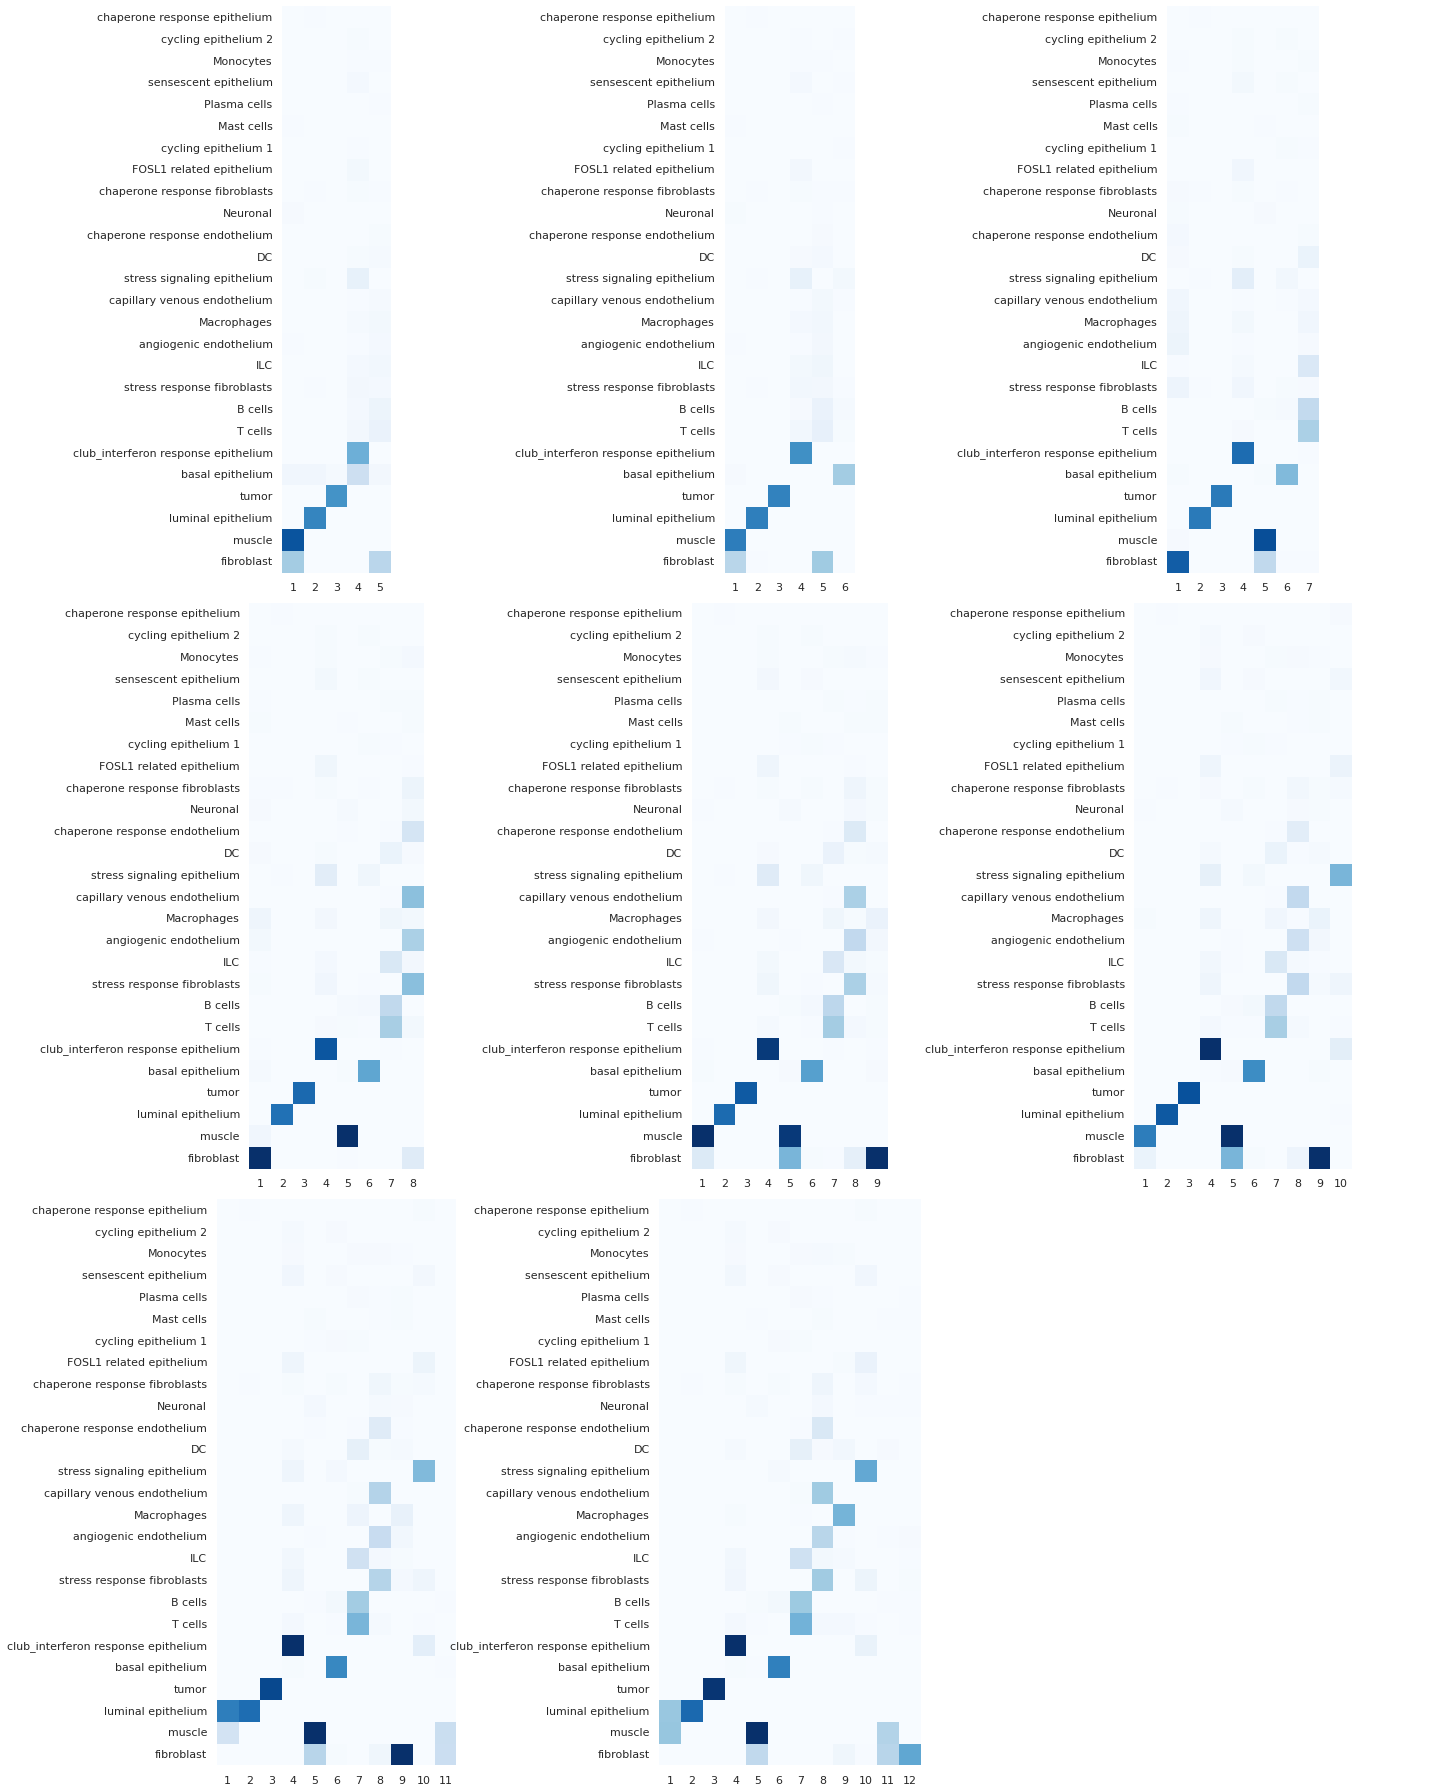

In [6]:
# Get inferred cell counts into a dataframe and get the prevalence order for NMF plots
df = pd.DataFrame(cell_mapping_dat.X, columns=cell_mapping_dat.var.index,index=cell_mapping_dat.obs.index)
celltype_order = df.sum().sort_values(ascending=True).index

# Plot the nmf results on two rows
# Create subplots with 2 rows and 4 columns
sns.set_theme(style='white',font_scale=1)
fig, axs = plt.subplots(3, 3, figsize=(20, 25))

for i, n_components in enumerate(component_range):

    nmf_res_for_plotting = nmf_res_dict[n_components].copy()
    nmf_res_for_plotting = nmf_res_for_plotting.loc[celltype_order]

    # Determine the position of the subplot on the grid
    row = i // 3
    col = i % 3
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(nmf_res_for_plotting, cmap='Blues', square=True, ax=axs[row, col], vmax=100,cbar=False)


axs[2,2].axis('off')
plt.tight_layout()

#plt.savefig('plots/nmf_components.pdf')
plt.show()


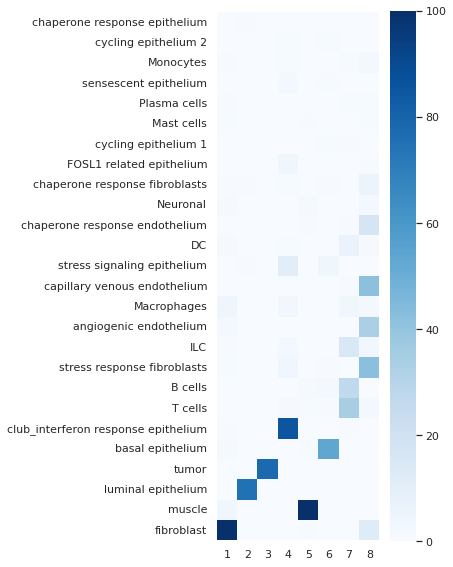

In [7]:
# Plot the nmf results on two rows
# Create subplots with 2 rows and 4 columns
fig, ax = plt.subplots(figsize=(5, 8))

n_components = 8

# Drop the redundant cell types prior to plotting
nmf_res_for_plotting_subset = nmf_res_dict[n_components].copy()
nmf_res_for_plotting_subset = nmf_res_for_plotting_subset.loc[celltype_order]
# Plot the heatmap on the corresponding subplot
sns.heatmap(nmf_res_for_plotting_subset, cmap='Blues', square=True, ax=ax, vmax=100,cbar=True)

plt.tight_layout()

#plt.savefig('plots/nmf_components_with_colorbar.pdf')
plt.show()


In [9]:

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/nmf_component_weights_for_celltypes.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in nmf_res_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    
    value.loc[celltype_order].to_excel(writer, sheet_name=str(key))

# Save and close the Excel writer
writer.save()

### Annotate the NMF factors

In [8]:
# Select the best number of factors and annotate them
tissue_region_names = {1:'Fibroblast', 2:'Luminal epithelium', 3:'Tumor', 4:'Club epithelium',
                      5:'Muscle', 6:'Basal epithelium', 7:'Immune', 8:'Endothelium'}

# Sorting out the colors for tissue regions (Set2 palette)
sorted_region_names = [tissue_region_names[i] for i in [3,2,6,4,7,8,1,5]]

tissue_region_colors = ['#fc8d62','#8da0cb','#66c2a5','#ffd92f','#a6d854','#e78ac3','#e5c494','#b3b3b3']
region_colors_dict = dict(zip(sorted_region_names,tissue_region_colors))

# Number 8 is the best fit
tissue_regions = nmf_res_dict[n_components].copy().rename(columns=tissue_region_names).loc[celltype_order][sorted_region_names]

In [9]:
# Spot identity is determined by simply choosing the factor with the highest nmf weight
obs_data = cell_mapping_dat.obs.copy().reset_index(drop=True)
nmf_obs_weights = pd.DataFrame(nmf_cell_weights_dict[n_components],columns=list(tissue_region_names.values()),index=cell_mapping_dat.obs_names)
nmf_obs_annot = nmf_obs_weights.idxmax(axis=1)

obs_data.index = cell_mapping_dat.obs_names
obs_data['nmf_weight_based_regions'] = nmf_obs_annot

print('The number of spots prior to filtering out spots based on pathology: {:d}\n'.format(len(obs_data)))
# Use the pathology annotation to perform filtering
obs_data = obs_data.loc[cell_type_abundances_pathology_filtered.index]

print('Region percentages out of {:d} total spots'.format(len(obs_data)))
(obs_data['nmf_weight_based_regions'].value_counts() / len(obs_data) * 100).round(1)


The number of spots prior to filtering out spots based on pathology: 123404

Region percentages out of 110681 total spots


Tumor                 21.4
Luminal epithelium    21.0
Muscle                18.8
Fibroblast            15.5
Basal epithelium      11.1
Immune                 5.3
Club epithelium        5.1
Endothelium            1.8
Name: nmf_weight_based_regions, dtype: float64

In [11]:
# Copy the region annotation into scanpy slide objects, build graph, save and plot

for sample in samples:

    # Read in the data
    slide = sc.read_h5ad('./data/normalized_visium/'+sample+'_normalized.h5ad')

    slide.obs['predicted_region'] = obs_data.loc[slide.obs_names]['nmf_weight_based_regions'].astype('category')

    # Only keep the categories that are present in the sample
    slide_categories = [s for s in sorted_region_names if s in slide.obs['predicted_region'].cat.categories]

    # Sort the categories
    slide.obs['predicted_region'] = slide.obs['predicted_region'].cat.reorder_categories(slide_categories)

    # Get the colors considering some might be missing
    slide.uns['predicted_region_colors'] = [region_colors_dict[region] for region in slide_categories]
    
    # Build the neighbor graph
    sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)

    # Add the relevant column information
    slide.obs['sample_id'] = sample
    slide.obs['sample_class'] = sample_id_masks[sample].split(' ')[0]
    
    # Format the obs columns so that there's no discreprancies
    slide.obs = slide.obs[['in_tissue','array_row','array_col','n_counts','size_factors','sample_id','sample_class','predicted_region']]

    # Save the slide objects to another directory
    slide.write_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')

    print(sample + ' done.')
    del slide

""" 
    fig,ax_plotting = plt.subplots(1,2,figsize=(18,9))
    sc.pl.spatial(slide,color='predicted_region',size=0,ax=ax_plotting[0],show=False,legend_loc=None)
    sc.pl.spatial(slide,color='predicted_region',size=1.5,ax=ax_plotting[1],show=False,alpha_img=0)
    plt.tight_layout()
    plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_side_by_side_nmf_obs_weight_based_tissue_regions_spatial.pdf')
    plt.clf()
     """
    

BPH_651 done.
BPH_665 done.
BPH_688 done.
BPH_652 done.
PC-03-6712 done.
PC_00_16338_II done.
PC_01_06342_VAS done.
PC_01_14451_OIK done.
PC_02_05601_OIK done.
PC_02_10136_VAS done.
PC_03_01669_TUTKV done.
PC_15420OIK done.
PC_4980 done.
PC_7875OIK done.
PC_05_08449_OIK_POST_0 done.
PC_05_13057_OIK_ANT_0 done.
PC_05_30627_VAS_ANT_0 done.
PC_06_02588_OIK_ANT_0 done.
PC_06_04581_OIK_POST_0 done.
PC_06_17800_VAS_POST_0 done.
PC_04_12646_VAS done.
PC_05_16831_VAS_POST_1 done.
PC_05_17668_OIK_ANT_1 done.
PC_05_24402_OIK_ANT2_1 done.
PC_06_03093_OIK_ANT_1 done.
PC_05_25866_OIK_POST_1 done.
PC_06_11108_VAS_POST_1 done.
PC_05_27153_OIK_POST_2 done.
PC_05_29927_VAS_POST_2 done.
PC_06_00786_VAS_ANT_2 done.
PC_06_04077_OIK_ANT_2 done.
PC_06_16086_VAS_POST_2 done.
P32030 done.
P32033 done.
P32037 done.
P32043 done.
P32055 done.
P32014 done.
P32036 done.
P32041 done.
P32044 done.
P32062 done.
P32084 done.
CRPC-278 done.
CRPC-489 done.
CRPC-697 done.
CRPC_530 done.
CRPC_531 done.


" \n    fig,ax_plotting = plt.subplots(1,2,figsize=(18,9))\n    sc.pl.spatial(slide,color='predicted_region',size=0,ax=ax_plotting[0],show=False,legend_loc=None)\n    sc.pl.spatial(slide,color='predicted_region',size=1.5,ax=ax_plotting[1],show=False,alpha_img=0)\n    plt.tight_layout()\n    plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_side_by_side_nmf_obs_weight_based_tissue_regions_spatial.pdf')\n    plt.clf()\n     "

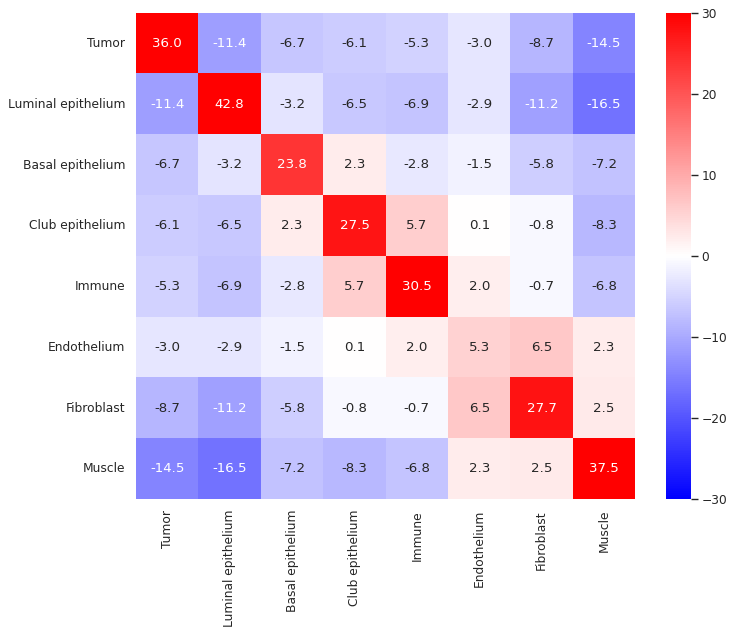

In [112]:
# This is in ALL samples
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in samples:
    
    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')
    sq.gr.nhood_enrichment(slide, cluster_key='predicted_region',show_progress_bar=False)
    
    mat = slide.uns['predicted_region_nhood_enrichment']['zscore'].copy()
    mat = np.nan_to_num(mat)

    missing = [c for c in sorted_region_names if c not in list(slide.obs['predicted_region'].cat.categories)]

    for missing_type in missing:

        insert_idx = list(sorted_region_names).index(missing_type)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

    summary_mat += mat
sns.set_theme(style='white')
fig,ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)/len(samples)
sns.heatmap(df,cmap='bwr',ax=ax,annot=True,fmt='.1f',center=0,vmin=-30,vmax=30)
plt.savefig('./plots/tissue_region_interaction_heatmap_all_samples_tampere_arneo.pdf')
plt.show()